In [1]:
# MSDS 498 - Final Project Notebook: Jay Vaidya & Ruchi Kumar
# Project Working Title: Corporate Earnings Call Sentiment Analysis & Time-Series Forecasting

In [2]:
# Import initial packages to be used in the project

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter

import statistics
import math
import os
import numpy as np
import pandas as pd
import time
import random
import string # to process standard python strings
import wikipedia
import gensim
import itertools
import re
import wget
import pprint as pp
import seaborn as sns
import pickle 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/jayvaidya/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# Download: 1) 'punkt' an unsupervised sentence tokenizer; 2) stopwords; and 3) wordnet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jayvaidya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jayvaidya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jayvaidya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# NOTE: RUCHI - You can ignore this cell, it is specific to my machine which needs to enable memory growth to permit both GPUs to be utilized
# Set memory growth to true to enable proper functioning of GPUs
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
# Set the current working directory
%cd "/home/jayvaidya/Documents/MSDS498"

/home/jayvaidya/Documents/MSDS498


In [6]:
# Load in the serialized dataset to be used in this analysis 
# Use pandas 'read_pickle' to decompress the file and generate a dataframe
data = pd.read_pickle('datasets/audited_transcript_data')

# At this stage, we will begin our exploration of the dataset in an attempt to understanding the underlying information contained therein, as well as the properties of the variables we will be using in our analysis

In [7]:
# View the head of the imported dataset
data.head()

,index,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
27,27,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,29900834.0,429604289.0,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
28,28,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,28062.0,429604289.0,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
571,571,54816745,1372076,44,4,257993,"Look, I see them in the same ballpark, just ov...",177698.0,545664372.0,"Halliburton Company, 2017 Earnings Call, Jan 2...",...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,CDK,None
691,691,78797340,2014164,104,4,150196,"Doug, do you want to…",318561.0,668928990.0,"Credit Acceptance Corporation, Q1 2020 Earning...",...,Financial Institutions,FINCOMP,Finance Companies,FINANCECO,Finance Company,USA,USA,MI,DIM0003,None
759,759,76655438,1952553,119,4,116006,"Yes, it's 1.2.",322121.0,261993510.0,"The Scotts Miracle-Gro Company, Q2 2014 Earnin...",...,Corporates,CORP,Industrials,5,Chemicals,USA,USA,OH,KAH0002,None


In [8]:
# Drop the duplicate 'index' column
data = data.drop(columns=['index'])
# Reindex the data so it can be better manipulated
data.reset_index(inplace=True)
data = data.drop(columns=['index'])
data

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,29900834.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
1,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,28062.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2,54816745,1372076,44,4,257993,"Look, I see them in the same ballpark, just ov...",177698.0,5.456644e+08,"Halliburton Company, 2017 Earnings Call, Jan 2...",2018-01-22,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,CDK,None
3,78797340,2014164,104,4,150196,"Doug, do you want to…",318561.0,6.689290e+08,"Credit Acceptance Corporation, Q1 2020 Earning...",2020-05-27,...,Financial Institutions,FINCOMP,Finance Companies,FINANCECO,Finance Company,USA,USA,MI,DIM0003,None
4,76655438,1952553,119,4,116006,"Yes, it's 1.2.",322121.0,2.619935e+08,"The Scotts Miracle-Gro Company, Q2 2014 Earnin...",2014-05-05,...,Corporates,CORP,Industrials,5,Chemicals,USA,USA,OH,KAH0002,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178428,50297000,1239202,38,4,325590,"Following up on what we said, last quarter, we...",28062.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2178429,50245816,1235781,56,4,283626,"Yes, which is traditional standing data center...",138672527.0,4.265464e+08,"MACOM Technology Solutions Holdings, Inc., Q2 ...",2017-04-25,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,MA,EJO0001,None
2178430,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
2178431,93263880,2460657,13,4,452213,Yes. Anytime. Absolutely. Appreciate it.,561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [9]:
# Looking at the first two entries, it appears as though there are some duplicate entries where the 'transcriptid', 'componentorder' and 
# 'componenttext' match, but the 'companyid' does not. This is an issue. In order to remove duplicates, let's use the 'drop_duplicates' function
# based on the column subsets just mentioned (excluding companyid)

data_no_dup = data.drop_duplicates(subset=['transcriptid', 'componentorder', 'componenttext'], keep='first')
data_no_dup

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,29900834.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2,54816745,1372076,44,4,257993,"Look, I see them in the same ballpark, just ov...",177698.0,5.456644e+08,"Halliburton Company, 2017 Earnings Call, Jan 2...",2018-01-22,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,CDK,None
3,78797340,2014164,104,4,150196,"Doug, do you want to…",318561.0,6.689290e+08,"Credit Acceptance Corporation, Q1 2020 Earning...",2020-05-27,...,Financial Institutions,FINCOMP,Finance Companies,FINANCECO,Finance Company,USA,USA,MI,DIM0003,None
4,76655438,1952553,119,4,116006,"Yes, it's 1.2.",322121.0,2.619935e+08,"The Scotts Miracle-Gro Company, Q2 2014 Earnin...",2014-05-05,...,Corporates,CORP,Industrials,5,Chemicals,USA,USA,OH,KAH0002,None
5,75885863,1930288,45,4,151107,Nick?,256689.0,6.560668e+08,"Vector Group Ltd., Q4 2019 Earnings Call, Feb ...",2020-02-28,...,Corporates,CORP,Industrials,6,Consumer Products,USA,USA,FL,PJ4,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178427,50297000,1239202,38,4,325590,"Following up on what we said, last quarter, we...",29900834.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2178429,50245816,1235781,56,4,283626,"Yes, which is traditional standing data center...",138672527.0,4.265464e+08,"MACOM Technology Solutions Holdings, Inc., Q2 ...",2017-04-25,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,MA,EJO0001,None
2178430,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
2178431,93263880,2460657,13,4,452213,Yes. Anytime. Absolutely. Appreciate it.,561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [ ]:
# NOTE: In looking at the number of rows left in the non-duplicate dataset, it appears as though approximately 600,000 duplicate 
# datapoints have been removed

In [10]:
# View the data types present in the dataframe
data_no_dup.dtypes

transcriptcomponentid         int64
transcriptid                  int64
componentorder                int64
transcriptcomponenttypeid     int64
transcriptpersonid            int64
                              ...  
region                       object
countrycode                  object
munistate                    object
analyst                      object
naic                         object
Length: 63, dtype: object

In [11]:
# Determine some of the unique properties of the dataset
print('The total number of data rows:', len(data_no_dup))
print('The total number of unique transcripts in the dataset:', len(data_no_dup['transcriptid'].unique()))
print('The total number of unique companies in the dataset:', len(data_no_dup['companyid'].unique()))
print('The total number of unique industries in the dataset:', len(data_no_dup['industrydescription'].unique()))

The total number of data rows: 1539725
The total number of unique transcripts in the dataset: 54247
The total number of unique companies in the dataset: 2304
The total number of unique industries in the dataset: 49


In [12]:
# Sort the dataset, first by date of transcript generation, then by transcript id and finally by component order
data_no_dup = data_no_dup.sort_values(by=['mostimportantdateutc', 'transcriptid', 'componentorder'])

In [13]:
# Now, once again, reset the index
data_no_dup.reset_index(inplace=True)
data_no_dup = data_no_dup.drop(columns=['index'])
data_no_dup

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,70732045,1806760,5,4,8971,"Yes Toni, for your first question you are quit...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
1,70732048,1806760,8,4,8971,Yeah let me first startup let say we are prett...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
2,70732051,1806760,11,4,8971,Well first of all I will let start very good q...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
3,70732054,1806760,14,4,8971,Well let’s say let’s look at this way as we fi...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
4,70732057,1806760,17,4,8971,"Yeah, that’s a good question. First of all as ...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539720,93263873,2460657,6,4,452213,"John, are you still there? Did you drop? We lo...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539721,93263876,2460657,9,4,452213,"Yes. Good morning. We've got you, John.",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539722,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539723,93263880,2460657,13,4,452213,Yes. Anytime. Absolutely. Appreciate it.,561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [14]:
print('The first datapoint date available in the dataset is',data_no_dup['mostimportantdateutc'][0])
print('The last datapoint date available in the dataset is',data_no_dup['mostimportantdateutc'].values[-1])

The first datapoint date available in the dataset is 2006-01-17
The last datapoint date available in the dataset is 2021-12-10


In [ ]:
# Source for assistance in EDA analysis: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

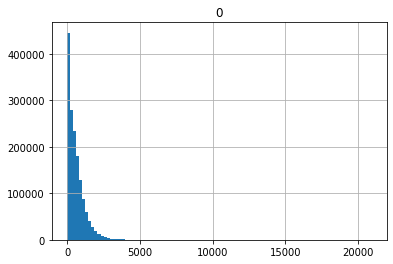

In [15]:
# Let's now plot the length of the 'componenttext' variable across the dataset by producing a histogram
# NOTE: The length method is returning the number of characters in a given entry, not the number of words and punctuations, or the like

comp_len = []
for i in range(len(data_no_dup)):
    current_len = len(data_no_dup['componenttext'][i])
    comp_len.append(current_len)

pd.DataFrame(comp_len).hist(bins=100)

In [16]:
print('Maximum component text length:', max(comp_len), 'tokens')
print('Minimum component text length:', min(comp_len), 'tokens')
print('Median component text length:', statistics.median(comp_len), 'tokens')

Maximum component text length: 20912 tokens
Minimum component text length: 2 tokens
Median component text length: 458 tokens


<AxesSubplot:>

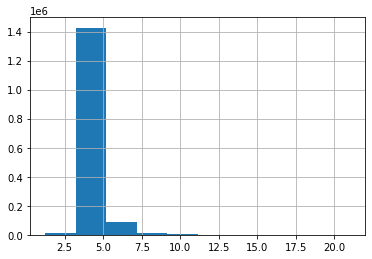

In [17]:
# Let's determine the average word length in each transcript
data_no_dup['componenttext'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

In [18]:
# In order to understand the text data present in the dataset, let's remove stopwords and look at the remaining word corpus
# Let's download the stopwords from the NLTK package and generate an object containing stop words

stop=set(stopwords.words('english'))

In [19]:
# Generate the corpus of words
corpus=[]
new= data_no_dup['componenttext'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

In [20]:
# Let's find the most common stop words used in the corpus by using a dict to count the number of occurrences of each stop word
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<BarContainer object of 10 artists>

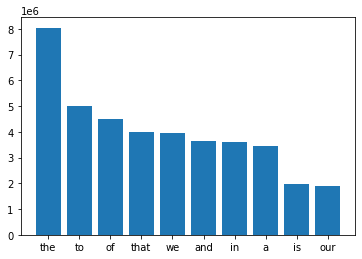

In [21]:
# Now let's plot the top stop words to visualize their usage
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

<AxesSubplot:>

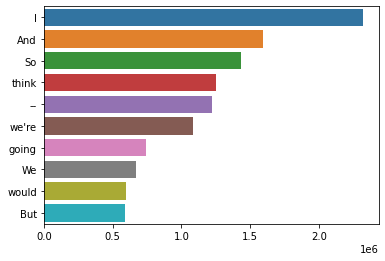

In [22]:
# Plot the most commonly occuring non-stop words
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [23]:
# Define a function for plotting n-grams
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

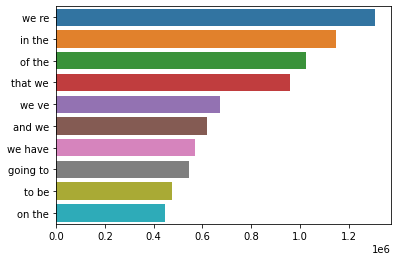

In [24]:
# Plot the top bi-grams
plot_top_ngrams_barchart(data_no_dup['componenttext'],2)

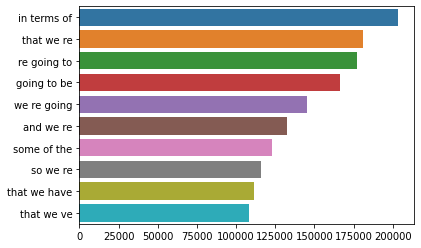

In [25]:
# Plot the top tri-grams
plot_top_ngrams_barchart(data_no_dup['componenttext'],3)

In [26]:
# Generate a simple function for preprocessing the text in order to undertaking some topic modelling steps. 
# This is just for the initial EDA portion of our analysis and does not represent the final pre-processing approach we will use in this project

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    
    # NOTE: For now, let's clean the docs without lemmatization or stemming
    # Lemmatization
    #lem = WordNetLemmatizer()
    #tokens = [lem.lemmatize(w) for w in tokens]

    return tokens

# Generate the corpus using the preprocessing step defined above
corpus= [clean_doc(doc) for doc in data_no_dup['componenttext']]

In [27]:
# Take a look at the first cleaned 'corpus' entry
corpus[0]

['first',
 'question',
 'quite',
 'current',
 'would',
 'operational',
 'achievement',
 'fourth',
 'quarter',
 'range',
 'excluding',
 'estate',
 'achieved',
 'second',
 'question',
 'thought',
 'million',
 'spilled',
 'million',
 'third',
 'million',
 'fourth',
 'consistent',
 'earlier',
 'think',
 'expense',
 'saving',
 'restructure',
 'remains',
 'billion',
 'million',
 'yeartoyear',
 'would',
 'actions',
 'designs',
 'drive',
 'competitive',
 'business',
 'especially',
 'services',
 'longer',
 'action',
 'competitive',
 'structure',
 'pricing',
 'flexibility',
 'allows',
 'better',
 'manage',
 'excluding',
 'labor']

In [28]:
# Define a function for plotting n-grams
def plot_top_ngrams_barchart_v2(text, n=2):
    stop=set(stopwords.words('english'))

    new= [clean_doc(doc) for doc in text]
    #new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

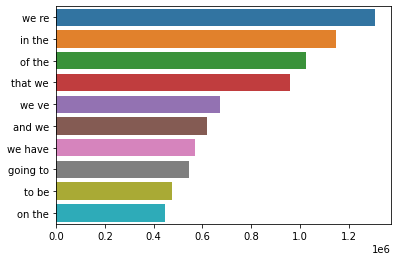

In [30]:
# Plot the top bi-grams from the cleaned text, this time
plot_top_ngrams_barchart_v2(data_no_dup['componenttext'],2)

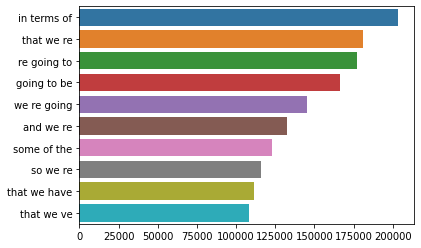

In [31]:
# Plot the top bi-grams from the cleaned text, this time
plot_top_ngrams_barchart_v2(data_no_dup['componenttext'],3)

In [33]:
# Using gensim Dictionary we will create a mapping of corpora words to intergers
dic=gensim.corpora.Dictionary(corpus)

# Then, we generate a bow corpus for each document; in 'corpus' each entry, or slice, represents a document or transcript
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [34]:
# Now we perform LDA topic modeling using Gensim
# NOTE: for the 'workers' parameter, this needs to be adjusted based on the number of cores available in your CPU; currently I'm using a machine with 24
# cores, so I have set workers = 20
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dic,                                    
                                   passes = 3,
                                   workers = 20)
lda_model.show_topics()

[(0,
  '0.045*"quarter" + 0.025*"think" + 0.018*"million" + 0.014*"going" + 0.014*"first" + 0.014*"would" + 0.013*"little" + 0.011*"second" + 0.010*"thats" + 0.009*"really"'),
 (1,
  '0.019*"think" + 0.018*"business" + 0.014*"really" + 0.013*"growth" + 0.012*"thats" + 0.012*"market" + 0.011*"going" + 0.011*"customers" + 0.008*"product" + 0.008*"products"'),
 (2,
  '0.035*"think" + 0.018*"going" + 0.013*"really" + 0.010*"thats" + 0.010*"would" + 0.009*"things" + 0.009*"right" + 0.008*"theres" + 0.008*"people" + 0.006*"business"'),
 (3,
  '0.023*"think" + 0.013*"thats" + 0.013*"would" + 0.012*"business" + 0.011*"going" + 0.009*"capital" + 0.009*"margin" + 0.008*"continue" + 0.008*"really" + 0.007*"growth"'),
 (4,
  '0.020*"think" + 0.017*"thats" + 0.014*"would" + 0.014*"going" + 0.009*"really" + 0.008*"right" + 0.006*"theres" + 0.005*"question" + 0.005*"point" + 0.005*"could"')]

In [35]:
# Look at the relative distribution of transcript counts by sector description
data_no_dup['industrydescription'].value_counts()

Information Technology                146126
Holding Company                       122484
Property & Real Estate                121406
Capital Goods                         108145
Energy                                107448
Health Care                            94616
Retailing                              90454
Consumer Products                      80592
Media & Entertainment                  54096
Transportation                         47712
Commercial & Professional Services     45948
Chemicals                              45700
Automobiles & Components               36114
Finance Company                        34048
Electric                               29950
Aerospace & Defense                    29024
Midstream Energy Companies             28940
Metals & Mining                        27007
Hotels & Gaming                        26250
Building Materials                     23690
Business and Consumer Services         23260
Paper & Forest Products                20252
Telecom Se

In [36]:
# Display the top 20 industries by value counts - we will consider only using these industries for our analysis
data_no_dup['industrydescription'].value_counts()[:20]

Information Technology                146126
Holding Company                       122484
Property & Real Estate                121406
Capital Goods                         108145
Energy                                107448
Health Care                            94616
Retailing                              90454
Consumer Products                      80592
Media & Entertainment                  54096
Transportation                         47712
Commercial & Professional Services     45948
Chemicals                              45700
Automobiles & Components               36114
Finance Company                        34048
Electric                               29950
Aerospace & Defense                    29024
Midstream Energy Companies             28940
Metals & Mining                        27007
Hotels & Gaming                        26250
Building Materials                     23690
Name: industrydescription, dtype: int64

In [37]:
print('Total number of datapoints in the top 20 industries:', data_no_dup['industrydescription'].value_counts()[:20].sum())
print('Percentage of data represented by top 20 industries:', 
      round(data_no_dup['industrydescription'].value_counts()[:20].sum()/data_no_dup['industrydescription'].value_counts().sum(),2))

Total number of datapoints in the top 20 industries: 1299750
Percentage of data represented by top 20 industries: 0.88


In [38]:
# Look at the unique company names under the 'Finance Company' industry set; because 'banks' are not included in the top 20 industry set, we want
# to ensure that a strong group of financial important companies enter our analysis;
# A review of the constituents of this subset appears to confirm that a number of large financial intermediaries are present in this list
data_no_dup[data_no_dup['industrydescription'] == data_no_dup['industrydescription'].value_counts().index[13]].companyname.unique()

array(['Allied Capital Corporation', 'Prospect Capital Corporation',
       'American Capital, Ltd.', 'Blackstone Mortgage Trust, Inc.',
       'Ares Capital Corporation',
       'National Rural Utilities Cooperative Finance Corporation',
       'MoneyGram International, Inc.', 'SLR Investment Corp.',
       'Ford Motor Credit Company LLC', 'The Western Union Company',
       'Jones Lang LaSalle Incorporated', 'Euronet Worldwide, Inc.',
       'Credit Acceptance Corporation', 'Ditech Holding Corporation',
       'Golub Capital BDC, Inc.', 'Apollo Investment Corporation',
       'DFC Global Corp.', 'World Acceptance Corporation', 'iStar Inc.',
       'RAIT Financial Trust', 'WEX Inc.', 'PHH Corporation',
       'Dynex Capital, Inc.', 'BlackRock Capital Investment Corporation',
       'Hercules Capital, Inc.', 'Main Street Capital Corporation',
       'Apollo Commercial Real Estate Finance, Inc.',
       'Starwood Property Trust, Inc.', 'FLEETCOR Technologies, Inc.',
       'Oaktree Spec

In [39]:
# In order to test some functions to be developed below, we will create a dummy dataset, mirroring the structure of the real dataset, 
# comprised of 100 datapoints, or 5 from each of the first 20 categories in the value_counts output above

# First, instantiate an empty list that will be populated with the 'dummy data'
dummy_data = []

# Generate a loop that goes through the top 20 industries, as identified view value counts, and then randomly selects 5 entries from 
# that industry for addition to the dummy data set
for i in range(0, 20):
    np.random.seed(1234)
    current_elements = np.random.choice(data_no_dup[data_no_dup['industrydescription'] == data_no_dup['industrydescription'].value_counts().index[i]].index.tolist(),
                                       size = 5,
                                       replace = False)
    for j in range(len(current_elements)):
        np.random.seed(1234)
        current_dummy = data_no_dup[data_no_dup['industrydescription'] == data_no_dup['industrydescription']].loc[current_elements[j]]
        dummy_data.append(current_dummy)

In [40]:
# Generate a new dataframe from the list of dicts just created
dummy_frame = pd.DataFrame.from_dict(dummy_data)
dummy_frame

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
468814,31993663,725629,49,4,104551,"No, that's -- we're telling you to model that ...",1462309.0,2.744932e+08,"Skyworks Solutions Inc., Q4 2014 Earnings Call...",2014-11-06,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,CA,CF0,None
1011148,60215643,1522835,8,4,324960,"Okay, Randy. So looking at SiP, we disclosed t...",124219.0,5.749385e+08,"Amkor Technology, Inc., Q2 2018 Earnings Call,...",2018-07-30,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,AZ,WER,None
17456,6334028,89865,85,4,93028,"I should say, Brendan, to your prior question ...",334962.0,8.493120e+07,"ATMI Inc., Q3 2010 Earnings Call, Oct 20, 2010",2010-10-20,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,CT,None,None
1132043,64895264,1646420,18,4,286913,"Yes. Suji, we're expecting both divisions to b...",27307.0,5.984101e+08,"Cypress Semiconductor Corporation, Q4 2018 Ear...",2019-01-31,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,CA,SES0001,None
1536742,92190391,2424326,16,4,388038,"Sure. Thanks, Joe, and thanks for the compleme...",310310.0,1.685657e+09,"Unisys Corporation, Q3 2021 Earnings Call, Nov...",2021-11-03,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,PA,SHP0006,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352231,74570920,1900832,8,4,92894,The exact words that Joe used when he was talk...,401541.0,6.519870e+08,"Lennox International Inc., Q4 2019 Earnings Ca...",2020-02-04,...,Corporates,CORP,Industrials,3,Building Materials,USA,USA,TX,PAG7181,None
654168,44544860,1062834,53,4,120289,"Yes, I think if you look at really what we've ...",294338.0,4.038350e+08,"Owens Corning, Q3 2016 Earnings Call, Oct 26, ...",2016-10-26,...,Corporates,CORP,Industrials,3,Building Materials,USA,USA,OH,NIN4616,None
1393007,76905869,1957524,20,4,92894,"Sure answer is yes to that final piece, which ...",401541.0,6.629082e+08,"Lennox International Inc., Q1 2020 Earnings Ca...",2020-04-20,...,Corporates,CORP,Industrials,3,Building Materials,USA,USA,TX,PAG7181,None
1285564,71862347,1836402,48,4,92894,I think that's just the lapping of the price i...,401541.0,6.396309e+08,"Lennox International Inc., Q3 2019 Earnings Ca...",2019-10-21,...,Corporates,CORP,Industrials,3,Building Materials,USA,USA,TX,PAG7181,None


In [ ]:
# Export this dummy frame to CSV for ease of manual annotation; we will then import the finished product, which will be used to test the BERT model framework
dummy_frame.to_csv('datasets/dummy_frame_no_annot.csv')

In [41]:
# Reload the annotated dummy dataset and clean it for application to BERT tests
dummy_frame_annot = pd.read_csv('datasets/dummy_frame_with_annot_trimmed_04.13.2022.csv')

In [42]:
dummy_frame_annot

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,Unnamed: 5,companyid
0,33195823,757421,66,4,260824,-1,411950
1,19074161,404331,28,4,223947,-3,250859
2,67193600,1711480,81,4,257944,2,30439
3,6333958,89865,15,4,93035,-1,334962
4,19510305,413268,9,4,120923,-3,252150
...,...,...,...,...,...,...,...
95,33912806,775609,50,4,274531,1,40084670
96,51417429,1270021,31,4,137417,-1,34817
97,7668185,114989,20,4,148773,-3,379868
98,48884376,1188990,11,4,116410,2,31153


In [43]:
# Rename the annotation id column (column 5)
dummy_frame_annot.rename(columns = {"Unnamed: 5": "Annot ID"}, inplace = True)

In [44]:
# View the head of the dataset
dummy_frame_annot.head()

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,Annot ID,companyid
0,33195823,757421,66,4,260824,-1,411950
1,19074161,404331,28,4,223947,-3,250859
2,67193600,1711480,81,4,257944,2,30439
3,6333958,89865,15,4,93035,-1,334962
4,19510305,413268,9,4,120923,-3,252150


In [45]:
# Generate a new dataframe that merges the annotation DF with the corresponding 'componenttext'; from this we will generate our X and y variables for the mode
new_dummy_df = pd.merge(dummy_frame_annot, data_no_dup,  how='inner', 
                        left_on=['transcriptcomponentid','transcriptid'], 
                        right_on = ['transcriptcomponentid','transcriptid'])
new_dummy_df = new_dummy_df[['transcriptcomponentid','transcriptid', 'Annot ID', 'companyid_x', 'componenttext']]

In [46]:
new_dummy_df

,transcriptcomponentid,transcriptid,Annot ID,companyid_x,componenttext
0,33195823,757421,-1,411950,"Well, obviously, it would flatten it out a bit..."
1,19074161,404331,-3,250859,Yes. Absolutely this business has fallen well ...
2,67193600,1711480,2,30439,"Yes, so, I believe you're referring to the com..."
3,6333958,89865,-1,334962,"If I look back over the last few years, I woul..."
4,19510305,413268,-3,252150,"All right. Thanks. Well, we're actually seeing..."
...,...,...,...,...,...
95,33912806,775609,1,40084670,"Thank you, everyone, for joining us today on t..."
96,51417429,1270021,-1,34817,I'll give you my thoughts. I think the little ...
97,7668185,114989,-3,379868,"Lee, looking at -- I mean, it's so difficult t..."
98,48884376,1188990,2,31153,"Yes, I guess, our sense on that, Garik, was we..."


In [47]:
# This BERT Model does not work with classifier values less than zero; we will use a dict to map our Annotation IDs to positive values for the purposes
# of fitting the model
mapping_dict = {-3:0, -2:1, -1:2, 0:3, 1:4, 2:5, 3:6}
new_dummy_df['Annot ID'].replace(mapping_dict, inplace=True)

In [48]:
new_dummy_df

,transcriptcomponentid,transcriptid,Annot ID,companyid_x,componenttext
0,33195823,757421,2,411950,"Well, obviously, it would flatten it out a bit..."
1,19074161,404331,0,250859,Yes. Absolutely this business has fallen well ...
2,67193600,1711480,5,30439,"Yes, so, I believe you're referring to the com..."
3,6333958,89865,2,334962,"If I look back over the last few years, I woul..."
4,19510305,413268,0,252150,"All right. Thanks. Well, we're actually seeing..."
...,...,...,...,...,...
95,33912806,775609,4,40084670,"Thank you, everyone, for joining us today on t..."
96,51417429,1270021,2,34817,I'll give you my thoughts. I think the little ...
97,7668185,114989,0,379868,"Lee, looking at -- I mean, it's so difficult t..."
98,48884376,1188990,5,31153,"Yes, I guess, our sense on that, Garik, was we..."


In [49]:
# We should find unique identifiers ranging from zero theu 6
new_dummy_df['Annot ID'].unique()

array([2, 0, 5, 4, 1, 3, 6])

In [50]:
# Generate train, validation and test datasets for the model to be fit below
from sklearn.model_selection import train_test_split

X = new_dummy_df.componenttext.values
y = new_dummy_df['Annot ID'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) # 0.25 x 0.8 = 0.2

In [ ]:
# Switching gears now to work on the BERT model that will be fine-tuned for our work
# Source code located at: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [51]:
# For this iteration of the model, we will be using PyTorch; we will import the appropriate packages here
import torch
import torch.nn as nn
from transformers import BertModel
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
from accelerate import Accelerator

In [52]:
# For package compatibility reasons, let's check the version of Python being used
from platform import python_version
print(python_version())

3.8.10


In [53]:
# Need to direct Torch to use the GPU
# Using the accelerate library by Hugging Face (https://huggingface.co/blog/accelerate-library)

#accelerator = Accelerator()
#device = accelerator.device

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: NVIDIA GeForce RTX 3070


In [ ]:
# If GPU is showing errors when fitting the BERT model, it is recommend we switch to CPU to engage in troubleshooting steps
#device = torch.device("cpu")

In [54]:
# Define a function that will preprocess text for preparation for the BERT model;
# NOTE: BERT was trained on full sentences, so less pre-processing needs to take place

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [55]:
# Demonstrate the preprocessing using an example
# Print sentence 0

print('Original: ', data_no_dup['componenttext'][1000])
print('Processed: ', text_preprocessing(data_no_dup['componenttext'][1000]))

Original:  Well, certainly. I think as we go through the build-up of our loan loss
reserve, it's something that we have to go through and document each and every
quarter. As non-performers increase as you seek just normal migration in credit,
I think there's the normal expectation that as charge-offs go up and this time
the cycle that provision will also end up going up just like it did in the
third quarter, we had ended up providing more than what we charged off. So,
that particular pattern could exist in future periods as we continue to go
through the cycle.
Processed:  Well, certainly. I think as we go through the build-up of our loan loss reserve, it's something that we have to go through and document each and every quarter. As non-performers increase as you seek just normal migration in credit, I think there's the normal expectation that as charge-offs go up and this time the cycle that provision will also end up going up just like it did in the third quarter, we had ended up prov

In [56]:
# Load the BERT tokenizer
# Set the maximum token length to be used in this iteration of the model; tokens after the max length are truncated
# NOTE: Need to change truncation so it occurs on the front, and not back, end of the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=128, truncation=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [57]:
# Before tokenizing, we need to specify the maximum length of our responses

# Concatenate train, val and test data
all_data = np.concatenate([X_train, X_val, X_test])

# Encode our concatenated data
encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_text])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (129 > 128). Running this sequence through the model will result in indexing errors


Max length:  475


In [60]:
# How to check the length of the longest entry in the dataset
# NOTE: Not needed for this exact exercise, but will be needed for final work
len_list = [len(entry) for entry in data_no_dup['componenttext']]
print(len(data_no_dup['componenttext'][len_list.index((max(len_list)))]))

20912


In [61]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', '\n', X[0], '\n')
print('Token IDs: ', '\n', token_ids, '\n')
print('Convert IDs tok Tokens: ', '\n', tokenizer.convert_ids_to_tokens(token_ids), '\n' )

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  
 Well, obviously, it would flatten it out a bit. You're still going to have big quarters in Q2 and Q3, but what you'll have maybe is a little flatter performance in 4 and 1. 

Token IDs:  
 [101, 2092, 1010, 5525, 1010, 2009, 2052, 4257, 6528, 2009, 2041, 1037, 2978, 1012, 2017, 1005, 2128, 2145, 2183, 2000, 2031, 2502, 7728, 1999, 1053, 2475, 1998, 1053, 2509, 1010, 2021, 2054, 2017, 1005, 2222, 2031, 2672, 2003, 1037, 2210, 4257, 3334, 2836, 1999, 1018, 1998, 1015, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Convert IDs tok Tokens:  
 ['[CLS]', 'well', ',', 'obviously', ',', 'it', 'would', 'flat', '##ten', 'it', 'out', 'a', 'bit', '.', 'you', "'", 're', 'still', 'going', 'to', 'have', 'big', 'quarters', 'in', 'q', '##2', 'and', 'q', '##3', ',', 'but', 'what', 'you', "'"

In [62]:
# We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [63]:
# View the first slice of the training labels tensor to better understand the data preparation steps
train_labels

tensor([3, 3, 5, 3, 4, 1, 2, 3, 4, 3, 1, 1, 4, 4, 6, 4, 4, 6, 2, 3, 6, 2, 3, 4,
        4, 4, 6, 5, 3, 4, 4, 3, 4, 3, 5, 2, 5, 3, 2, 5, 3, 2, 4, 4, 6, 3, 3, 0,
        2, 4, 3, 3, 5, 6, 4, 4, 2, 0, 0, 6])

In [64]:
# Check to ensure that each of the classification categories are represented in our train, validation and test datasets
# by viewing the unique values in each dataset, which should align
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


In [65]:
# The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class 
# so we can specify our own choice of classifiers.

# Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward 
# neural network as our classifier.

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 7

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #self.bert = nn.DataParallel(BertModel.from_pretrained('bert-base-uncased'))

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [66]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    
    # NEW LINE ADDED BY JAY
    #bert_classifier = nn.DataParallel(bert_classifier)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [67]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    #torch.manual_seed(seed_value)
    #torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [68]:
# Try to clear GPU cache before running model
torch.cuda.empty_cache()
import gc
#del variables
gc.collect()

20

In [69]:
# Define a function to display the GPU memory utilization so we can help diagnose potential memory constraint issues
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [70]:
print_gpu_utilization()

GPU memory occupied: 574 MB.


In [71]:
# Check the number of recognized GPUs by Torch on this device
torch.cuda.device_count()

2

In [72]:
# By adding this first line of code to our executables, we can derive more detailed error messages if issues arise with the GPU
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Initialize the BERTClassifier model and run two epochs on the training data
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=20)
train(bert_classifier, train_dataloader, val_dataloader, epochs=20, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    3    |   1.933992   |     -      |     -     |   1.03   
----------------------------------------------------------------------
   1    |    -    |   1.933992   |  1.978820  |   6.25    |   1.10   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    3    |   1.778666   |     -      |     -     |   0.66   
----------------------------------------------------------------------
   2    |    -    |   1.778666   |  2.006191  |   18.75   |   0.71   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

In [ ]:
# NOTE: The above demonstration of fitting the BERT model was solely as an exercise in demonstrating the feasibility of the task;
# Now, we will turn to generating an annotated dataset containing 1,000 datapoints. This dataset will form the first stage of our
# analytical task in this project.

In [73]:
# Generate a subset of our 'data_no_dup' dataset in which all entries in the 'componettext' field contain a minimum of 10 tokens, in order to eliminate
# some of the least useful entries that fail to reveal sentiments and are merely one, or several word answers to posed questions
data_no_dup_min_10 = []

for i in range(len(data_no_dup)):
    if len(data_no_dup['componenttext'].loc[i].split()) >= 10:
        data_no_dup_min_10.append(data_no_dup.loc[i]);
    else: pass

In [74]:
# Generate a dataframe from this new subset dataset
data_no_dup_min_10 = pd.DataFrame.from_dict(data_no_dup_min_10)
data_no_dup_min_10

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,70732045,1806760,5,4,8971,"Yes Toni, for your first question you are quit...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
1,70732048,1806760,8,4,8971,Yeah let me first startup let say we are prett...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
2,70732051,1806760,11,4,8971,Well first of all I will let start very good q...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
3,70732054,1806760,14,4,8971,Well let’s say let’s look at this way as we fi...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
4,70732057,1806760,17,4,8971,"Yeah, that’s a good question. First of all as ...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539718,93249236,2460158,96,4,115049,No. I was just going to add that we do want to...,279534.0,1.759968e+09,"Hovnanian Enterprises, Inc., Q4 2021 Earnings ...",2021-12-09,...,Structured Finance,REC,Real Estate Companies,PROPRE,Property & Real Estate,USA,USA,NJ,WIM0002,None
1539719,93249238,2460158,98,4,115049,"Thank you very much. As we said, we're pleased...",279534.0,1.759968e+09,"Hovnanian Enterprises, Inc., Q4 2021 Earnings ...",2021-12-09,...,Structured Finance,REC,Real Estate Companies,PROPRE,Property & Real Estate,USA,USA,NJ,WIM0002,None
1539720,93263873,2460657,6,4,452213,"John, are you still there? Did you drop? We lo...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539722,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [75]:
data_no_dup_min_10['industrydescription'].value_counts()[:20].sum()

1146361

In [76]:
# We'll use the loop generated above to create a "generate_data" function that can be used to produce the required random samples from the 
# industries we wish to scrutinize

def generate_data(seed, dataset, series_name, num_obs_per_series, replace=False):

    # First, instantiate an empty list that will be populated with the data, as it is randomly selected from each industry group
    data = []

    # Generate a loop that goes through the top 20 industries, as identified view value counts, and then randomly selects 5 entries from that 
    # industry for addition to the dummy data set
    for i in range(0, 20):
        # Set a seed for reproducibility of results
        np.random.seed(seed)
        # This code produces a random list of the index location of 50 elements for each of the top 20 industry subsets
        current_elements = np.random.choice(
            dataset[dataset[series_name] == dataset[series_name].value_counts().index[i]].index.tolist(),
            size = num_obs_per_series,
            replace = replace)
        
        # Using the list of index locations above, this loop appends each row associated with a given index item to a list, generating a list of dicts
        for j in range(len(current_elements)):
            # Set a seed for reproductibility of results
            np.random.seed(seed)
            current_obs = dataset[dataset[series_name] == dataset[series_name]].loc[current_elements[j]]
            data.append(current_obs)
    
    # return a dataframe of the obtained data
    return pd.DataFrame.from_dict(data)

In [ ]:
# Use the function defined above to generate a 1,000 point dataset upon which sentiment annotations can be made
obs_subset_for_annot = generate_data(seed=1234, dataset=data_no_dup_min_10, series_name='industrydescription', num_obs_per_series=50)

In [ ]:
# Take the output dataset and remove all columns outside of transcript component id, transcript id, company id, company name and component text
# Retaining these key identiers will permit for merging with the broader dataset, if needed, at a later point in time
obs_subset_for_annot_trimmed = obs_subset_for_annot[['transcriptcomponentid', 'transcriptid', 'companyid', 
                                                                         'companyname', 'componenttext']]
# Send the CSV of this new dataset to file
obs_subset_for_annot_trimmed.to_csv('datasets/1000_datapoints_annotation_set.csv')
# View the head and tail of this new dataset
obs_subset_for_annot_trimmed

In [ ]:
# Let's also generate a shuffled version of the above datatset, so the sectors represented in the dataset are not all shown together, which could lead
# to distortions in rankings if sector-level language influences sentiment scoring by annotators
from sklearn.utils import shuffle

# Shuffle the dataframe
obs_subset_for_annot_trimmed_shuffled = shuffle(obs_subset_for_annot_trimmed)
# Send the shuffled dataframe to CSV
obs_subset_for_annot_trimmed_shuffled.to_csv('datasets/1000_datapoints_annotation_set_shuffled.csv')
# View a slice of the shuffled dataframe
obs_subset_for_annot_trimmed_shuffled

In [77]:
# Instantiate an instance of the classifier model so we can view some of the descriptive information available regarding the model
test_model = BertClassifier()

In [78]:
# View the configuration of the model (i.e. layers, outputs, etc.)
test_model

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
# View the parameters weights of the model
#for para in test_model.parameters():
#    print(para)

In [ ]:
# Let's now load in both of the annotator's datasets

In [79]:
# Read in first annotator's dataset
jdv_annot = pd.read_csv('datasets/1000_datapoints_annotation_set_shuffled_JayAnnot_04.19.2022.csv')
jdv_annot

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2
...,...,...,...,...,...,...,...
995,1473535,82312408,2094667,334158,Ingersoll Rand Inc.,Sure. Yes. So let me kind of take them in piec...,1
996,1098188,63457785,1610373,84223462,"Phillips Edison & Company, Inc.","Sure. Tom, as you know, our current annual div...",0
997,620056,43058235,1022183,183811756,"Press Ganey Holdings, Inc.","Sure, happy to do that. So the nursing perform...",2
998,873979,53941617,1345650,270315,Esterline Technologies Corporation,"Yes. I think that phasing is very, very import...",-2


In [80]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
jdv_annot.dtypes

Unnamed: 0                int64
transcriptcomponentid     int64
transcriptid              int64
companyid                 int64
companyname              object
componenttext            object
Rating                    int64
dtype: object

In [81]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
jdv_annot['Rating'].unique()

array([ 0,  2, -1,  3,  1, -2, -3])

<AxesSubplot:xlabel='Rating', ylabel='count'>

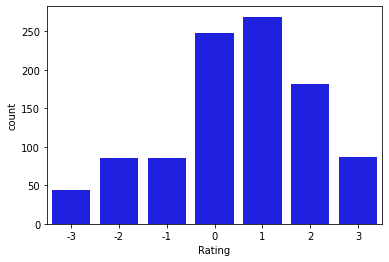

In [82]:
# Generat a histogram of the categoricals from Jay's annotations
# NOTE: The categoricals skew in the positive direction; also, neutral, or near-neutral ratings are most frequent
sns.countplot(jdv_annot['Rating'], color='blue')

In [83]:
# Read in the second annotator's dataset and rename the column with the annotation
rk_annot =pd.read_csv('datasets/RK_1000_datapoints_annotation_set_shuffled.csv')
rk_annot = rk_annot.rename(columns={'RK Annotation':'Rating'})
rk_annot

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0.0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0.0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",1.0
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1.0
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",-1.0
...,...,...,...,...,...,...,...
995,1473535,82312408,2094667,334158,Ingersoll Rand Inc.,Sure. Yes. So let me kind of take them in piec...,1.0
996,1098188,63457785,1610373,84223462,"Phillips Edison & Company, Inc.","Sure. Tom, as you know, our current annual div...",0.0
997,620056,43058235,1022183,183811756,"Press Ganey Holdings, Inc.","Sure, happy to do that. So the nursing perform...",1.0
998,873979,53941617,1345650,270315,Esterline Technologies Corporation,"Yes. I think that phasing is very, very import...",-2.0


In [84]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
rk_annot.dtypes

Unnamed: 0                 int64
transcriptcomponentid      int64
transcriptid               int64
companyid                  int64
companyname               object
componenttext             object
Rating                   float64
dtype: object

In [85]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
rk_annot['Rating'].unique()

array([ 0.,  1., -1., -3.,  2.,  3., -2., nan])

In [86]:
# Determine which row has nan value
rows_with_nan = [index for index, row in rk_annot.iterrows() if row.isnull().any()]
print(rows_with_nan)

[376]


In [87]:
rk_annot.loc[376]

Unnamed: 0                                                         1237279
transcriptcomponentid                                             69780475
transcriptid                                                       1782072
companyid                                                        555811978
companyname                                 Wyndham Hotels & Resorts, Inc.
componenttext            I think as we look at the opportunities that a...
Rating                                                                 NaN
Name: 376, dtype: object

In [88]:
# Update row value with annotator rating then recast the series as an int instead of float type
rk_annot['Rating'][376] = 2
rk_annot['Rating'] = rk_annot['Rating'].astype(int)

In [89]:
# Re-Check to make sure the annotation ranking series only contains the datatypes and values that are expected
rk_annot['Rating'].unique()

array([ 0,  1, -1, -3,  2,  3, -2])

<AxesSubplot:xlabel='Rating', ylabel='count'>

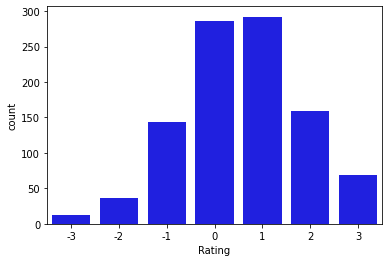

In [90]:
# Generat a histogram of the categoricals from RK's annotations
# NOTE: The categoricals skew in the positive direction; also, neutral, or near-neutral ratings are most frequent
sns.countplot(rk_annot['Rating'], color='blue')

In [91]:
# Now let's go about doing some EDA on the two annotation sets, in comparison to one another
# We begin by merging the two datasets

annot_comb = pd.merge(jdv_annot, rk_annot[['transcriptcomponentid','Rating']],on='transcriptcomponentid', how='left')
annot_comb

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating_x,Rating_y
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0,0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0,0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2,1
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1,-1
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2,-1
...,...,...,...,...,...,...,...,...
995,1473535,82312408,2094667,334158,Ingersoll Rand Inc.,Sure. Yes. So let me kind of take them in piec...,1,1
996,1098188,63457785,1610373,84223462,"Phillips Edison & Company, Inc.","Sure. Tom, as you know, our current annual div...",0,0
997,620056,43058235,1022183,183811756,"Press Ganey Holdings, Inc.","Sure, happy to do that. So the nursing perform...",2,1
998,873979,53941617,1345650,270315,Esterline Technologies Corporation,"Yes. I think that phasing is very, very import...",-2,-2


In [92]:
# Run some loops to better understand the two annotation series; how are they alike and how do they differ

diff_sign = []

# This first loop appends each of the entries in which the sign of the first annotator differs from the sign of the second annotator
for i in range(len(annot_comb)):
    if (np.sign(annot_comb.loc[i]['Rating_x']) == np.sign(annot_comb.loc[i]['Rating_y'])) == False:
        diff_sign.append(annot_comb.loc[i])
    else:
        pass

# Instantiate empty lists to be populated by the loops below
two_diff = []
three_diff = []
four_diff = []
five_diff = []
six_diff = []

# By using a series of if, elif statements to populate the just-created empty lists we will produce lists for each of the the categories of
# annotation differentials, from two to six

for i in range(len(annot_comb)):
    if np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 2:
        two_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 3:
        three_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 4:
        four_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 5:
        five_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 6:
        six_diff.append(annot_comb.loc[i])
    else:
        pass

In [93]:
# Print out the number of entries in each list
print('two cats apart:', len(two_diff))
print('three cats apart:', len(three_diff))
print('four cats apart:', len(four_diff))
print('five cats apart:', len(five_diff))
print('six cats apart:', len(six_diff))

two cats apart: 116
three cats apart: 40
four cats apart: 12
five cats apart: 2
six cats apart: 0


In [94]:
# Create CSVs from each list for manual review
pd.DataFrame.from_dict(two_diff).to_csv('datasets/review_set/two_diff.csv')
pd.DataFrame.from_dict(three_diff).to_csv('datasets/review_set/three_diff.csv')
pd.DataFrame.from_dict(four_diff).to_csv('datasets/review_set/four_diff.csv')
pd.DataFrame.from_dict(five_diff).to_csv('datasets/review_set/five_diff.csv')

In [ ]:
# The manual review occurred, for the escalated datapoints, and now the updated annotations need to be imported
# Finally, all data needs to be merged and we need to prepare the 'X' and 'y' datasets for the training of our NLP model

In [95]:
# Read the CSVs into pandas dataframes
three_diff_up = pd.read_csv('datasets/review_set/three_diff_jvrk_updated.csv')
four_diff_up = pd.read_csv('datasets/review_set/four_diff_jvrk_updated.csv')
five_diff_up = pd.read_csv('datasets/review_set/five_diff_jvrk_updated.csv')

In [96]:
# Rename the new jointly-rated column on the end
three_diff_up.rename(columns = {"Unnamed: 9": "Rating_comb"}, inplace = True)
four_diff_up.rename(columns = {"Unnamed: 9": "Rating_comb"}, inplace = True)
five_diff_up.rename(columns = {"Unnamed: 9": "Rating_comb"}, inplace = True)

# Concatenate the updated annotated sets into one dataframe
comb_diff_up = pd.concat([three_diff_up, four_diff_up, five_diff_up])

In [97]:
# Now we need to merge all of our rating data into one set so we can clean it and get to a single rating per annotated entry

annot_comb_final = pd.merge(annot_comb, comb_diff_up[['transcriptcomponentid','Rating_comb']],right_on='transcriptcomponentid',
                            left_on='transcriptcomponentid', how='left')

In [98]:
# There were a total of 54 entries that required escalation and review, so if we count the number of NaN values in the new 'Rating_comb'
# column we should find 946 NaN entries, if the previous merges worked correctly
annot_comb_final['Rating_comb'].isna().sum()

946

In [99]:
# View the head and tail of the new dataset
annot_comb_final[:10]

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating_x,Rating_y,Rating_comb
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0,0,NaN
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0,0,NaN
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2,1,NaN
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1,-1,NaN
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2,-1,-1.0
5,761096,48869751,1188741,368607,Fresh Del Monte Produce Inc.,"Jonathan, the Chilean business this year compa...",-1,-3,NaN
6,1501482,83559605,2123382,299081,"Dynex Capital, Inc.",Sure. Yes. The implied -- what we're seeing to...,3,2,NaN
7,1362486,75137699,1911766,528325,Moody's Corporation,Maybe a big place for me to start is really ju...,3,2,NaN
8,1524384,90907348,2382598,112302,"AutoNation, Inc.",So it's -- this is Mike Jackson. If I will -- ...,1,0,NaN
9,1088686,63174107,1601966,275573,"National Retail Properties, Inc.","And Spenser, you asked about vacant -- about l...",1,0,NaN


In [100]:
# Now we need to implement our rating procedures, as outlined in our project write-up

# Rule 1: For any entry in which both annotators ratings are two, or fewer, categorical ratings apart (integers ranging from -3 to +3, with 0 inclusive)
# we will average the two ratings and round up for positive numbers and down for negative numbers. This, in effect, will help to polarize 
# the sentiment rankings

# Rule 2: For the entries that were reviewed and rated using the escalation procedures, no further edits need to be made, these reflect final ratings

Final_Rating = []

for i in range(len(annot_comb_final)):
    if np.absolute((annot_comb_final.loc[i]['Rating_x'] - annot_comb_final.loc[i]['Rating_y'])) <= 2:
        if np.sign((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])) == -1:
            rating = int(math.floor((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])/2))
        elif np.sign((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])) == 1:
            rating = int(math.ceil((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])/2))
        else:
            rating = int(0)
    else:
        rating = int(annot_comb_final.loc[i]['Rating_comb'])
    
    Final_Rating.append(rating)

In [101]:
# If our previous step worked successfully, seven unique integers should be present in the 'Final_Rating' list we generated
np.unique(Final_Rating)

array([-3, -2, -1,  0,  1,  2,  3])

In [102]:
# Now append the new list to the dataframe used to generate the ratings
annot_comb_final['Final_Rating'] = Final_Rating
annot_comb_final[:20]

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating_x,Rating_y,Rating_comb,Final_Rating
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0,0,NaN,0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0,0,NaN,0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2,1,NaN,2
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1,-1,NaN,-1
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2,-1,-1.0,-1
5,761096,48869751,1188741,368607,Fresh Del Monte Produce Inc.,"Jonathan, the Chilean business this year compa...",-1,-3,NaN,-2
6,1501482,83559605,2123382,299081,"Dynex Capital, Inc.",Sure. Yes. The implied -- what we're seeing to...,3,2,NaN,3
7,1362486,75137699,1911766,528325,Moody's Corporation,Maybe a big place for me to start is really ju...,3,2,NaN,3
8,1524384,90907348,2382598,112302,"AutoNation, Inc.",So it's -- this is Mike Jackson. If I will -- ...,1,0,NaN,1
9,1088686,63174107,1601966,275573,"National Retail Properties, Inc.","And Spenser, you asked about vacant -- about l...",1,0,NaN,1


In [103]:
# This BERT Model does not work with classifier values less than zero; we will use a dict to map our Annotation IDs to positive values for the purposes
# of fitting the model
mapping_dict = {-3:0, -2:1, -1:2, 0:3, 1:4, 2:5, 3:6}
annot_comb_final['Final_Rating'].replace(mapping_dict, inplace=True)

In [104]:
# Generate train, validation and test datasets for the model to be fit below

X = annot_comb_final.componenttext.values
y = annot_comb_final['Final_Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) # 0.25 x 0.8 = 0.2

In [105]:
# Concatenate train, val and test data
all_data = np.concatenate([X_train, X_val, X_test])

# Encode our concatenated data
encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

In [106]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', '\n', X[0], '\n')
print('Token IDs: ', '\n', token_ids, '\n')
print('Convert IDs tok Tokens: ', '\n', tokenizer.convert_ids_to_tokens(token_ids), '\n' )

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  
 Some of them have. Some of them are the funded loans that are on the balance sheet held for sale and some of them are pipeline loans that haven't closed yet. So it would not be inclusive of the expenses to be incurred for closing. 

Token IDs:  
 [101, 2070, 1997, 2068, 2031, 1012, 2070, 1997, 2068, 2024, 1996, 6787, 10940, 2008, 2024, 2006, 1996, 5703, 7123, 2218, 2005, 5096, 1998, 2070, 1997, 2068, 2024, 13117, 10940, 2008, 4033, 1005, 1056, 2701, 2664, 1012, 2061, 2009, 2052, 2025, 2022, 18678, 1997, 1996, 11727, 2000, 2022, 22667, 2005, 5494, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Convert IDs tok Tokens:  
 ['[CLS]', 'some', 'of', 'them', 'have', '.', 'some', 'of', 'them', 'are', 'the', 'funded', 'loans', 'that', 'are', 'on', 'the', 'balance', 'sheet', 'held', 'for', 'sa

In [107]:
# We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [108]:
# Check to ensure that each of the classification categories are represented in our train, validation and test datasets
# by viewing the unique values in each dataset, which should align
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


In [109]:
# By adding this first line of code to our executables, we can derive more detailed error messages if issues arise with the GPU
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Initialize the BERTClassifier model and run two epochs on the training data
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.810796   |     -      |     -     |   3.52   
   1    |   37    |   1.799475   |     -      |     -     |   2.80   
----------------------------------------------------------------------
   1    |    -    |   1.805731   |  1.647578  |   37.50   |   6.84   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   1.647735   |     -      |     -     |   3.53   
   2    |   37    |   1.564434   |     -      |     -     |   2.80   
----------------------------------------------------------------------
   2    |    -    |   1.610469   |  1.562445  |   39.90   |   6.84   
----------------------------------------------------------------

In [ ]:
# Re-run BERT, but this time mapping to only 3 categories, pos, neg and neutral

In [110]:
annot_comb_final['Final_Rating'] = Final_Rating
mapping_dict = {-3:0, -2:0, -1:1, 0:1, 1:1, 2:2, 3:2}
annot_comb_final['Final_Rating'].replace(mapping_dict, inplace=True)

In [111]:
# Generate train, validation and test datasets for the model to be fit below

X = annot_comb_final.componenttext.values
y = annot_comb_final['Final_Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) # 0.25 x 0.8 = 0.2

In [112]:
# Concatenate train, val and test data
all_data = np.concatenate([X_train, X_val, X_test])

# Encode our concatenated data
encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

In [113]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', '\n', X[0], '\n')
print('Token IDs: ', '\n', token_ids, '\n')
print('Convert IDs tok Tokens: ', '\n', tokenizer.convert_ids_to_tokens(token_ids), '\n' )

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  
 Some of them have. Some of them are the funded loans that are on the balance sheet held for sale and some of them are pipeline loans that haven't closed yet. So it would not be inclusive of the expenses to be incurred for closing. 

Token IDs:  
 [101, 2070, 1997, 2068, 2031, 1012, 2070, 1997, 2068, 2024, 1996, 6787, 10940, 2008, 2024, 2006, 1996, 5703, 7123, 2218, 2005, 5096, 1998, 2070, 1997, 2068, 2024, 13117, 10940, 2008, 4033, 1005, 1056, 2701, 2664, 1012, 2061, 2009, 2052, 2025, 2022, 18678, 1997, 1996, 11727, 2000, 2022, 22667, 2005, 5494, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Convert IDs tok Tokens:  
 ['[CLS]', 'some', 'of', 'them', 'have', '.', 'some', 'of', 'them', 'are', 'the', 'funded', 'loans', 'that', 'are', 'on', 'the', 'balance', 'sheet', 'held', 'for', 'sa

In [114]:
# We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [115]:
# Check to ensure that each of the classification categories are represented in our train, validation and test datasets
# by viewing the unique values in each dataset, which should align
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1 2]
[0 1 2]
[0 1 2]


In [116]:
# Try to clear GPU cache before running model
torch.cuda.empty_cache()
import gc
#del variables
gc.collect()

10

In [117]:
# By adding this first line of code to our executables, we can derive more detailed error messages if issues arise with the GPU
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Initialize the BERTClassifier model and run two epochs on the training data
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.336444   |     -      |     -     |   3.57   
   1    |   37    |   1.036352   |     -      |     -     |   2.82   
----------------------------------------------------------------------
   1    |    -    |   1.202192   |  0.964442  |   58.17   |   6.91   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.994932   |     -      |     -     |   3.53   
   2    |   37    |   0.890661   |     -      |     -     |   2.81   
----------------------------------------------------------------------
   2    |    -    |   0.948285   |  0.840566  |   67.31   |   6.85   
----------------------------------------------------------------

In [118]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0  77]
 [  1 331]
 [  2 192]]
